# Entrega 4 - Predictor de muerte de pacientes con HIV utilizando redes neuronales y regresión logística


|**Grupo 26**       |                     |
|-------------------|---------------------|
| Nombre            | C.I                 |
| Agustín Martínez  | 5.074.743-0         |
| Joaquín Mezquita  | 5.239.865-9         |
| Nicolás Núñez     | 5.127.722-0         |

## 1. Objetivo

El objetivo principal de esta tarea es construir un modelo de regresión logística y diferentes redes neuronales para predecir la muerte de pacientes bajo observación por HIV. Para ello, utilizaremos el dataset `AIDS Clinical Trials Group Study 175` tomando como valor a predecir el indicador de censura `cid`.

El indicador de censura puede tomar dos valores "censoring" o "failure". La censura ocurre cuando un valor de una observación solo se conoce parcialmente. 

En este caso ocurre cuando el experimento termina en un momento determinado, tras el cuál los pacientes todavía vivos quedan censurados por la derecha.  

Luego del momento de la última observación no se conocen datos sobre la muerte o supervivencia de los pacientes. Por lo que se puede tomar únicamente el caso "failure" como la muerte de un paciente.

In [1]:
import pandas as pd
import torch.optim as optim

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Objetivo a predecir
OBJETIVO = 'cid'

dataset = pd.read_csv('data.csv')

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import importlib

import utilidades
import modelos
import entrenador

from modelos import *
from entrenador import *

importlib.reload(utilidades)
importlib.reload(entrenador)
importlib.reload(modelos)

<module 'modelos' from '/root/work/modelos.py'>

## 2. Diseño del predictor

 ### 2.1 Entrenamiento del predictor y evaluación.

Para realizar el entrenamiento, ajuste de la solución y evaluación del modelo, el conjunto de datos es separado en 3 particiones:

- Entrenamiento (80%): Utilizado para entrenar los diferentes modelos.
- Validación (10% del conjunto de entrenamiento): Para ajustar los valores de los hiperparametros.
- Evaluación (20%): Para calcular las métricas de los modelos una vez entrenados.

Además, a la hora de separarlos, utilizamos el parámetro `stratify=Y` de forma que la distribución de la columna `cid` sea similar en los 3 subconjuntos.

Al momento de evaluar las soluciones se utilizan las siguientes métricas, calculadas con `scikit-learn`:

- Accuracy: $ \frac{TP + TN}{TP + TN + FP + FN}$
- Precision: $ \frac{TP}{TP + FP}$
- Recall: $ \frac{TP}{TP + FN}$
- F1: $ \frac{2 \cdot Precision}{Precision + Recall} $
- Pérdida del modelo

Al generar los conjuntos de datos, se eliminan los atributos `pidnum` al ser este un metadato y no un dato de la realidad que influya en el resultado y `time` a pedido de la letra.

In [3]:
X = dataset.copy().drop(columns=[OBJETIVO, 'pidnum', 'time'])
Y = dataset[OBJETIVO].copy()

X_train_completo, X_test, Y_train_completo, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 12345, stratify=Y)
X_train, X_validacion, Y_train, Y_validacion = train_test_split(X_train_completo, Y_train_completo, test_size=0.1, random_state=12345, stratify=Y_train_completo)

### 2.2 Preprocesamiento de los conjuntos de datos

Antes de entrenar los modelos, se preprocesan los conjuntos de datos, aplicando:

- Normalización de atributos: Se escalan los atributos para que tengan las propiedades de una distribución normal estándar, con $\mu = 0$ y $\sigma = 1$, para que los atributos tengan órdenes de magnitud similares.
- One-Hot Encoding: Se crean atributos nuevos por cada valor posible de los atributos categóricos, siendo estos `strat` y `trt`.

In [4]:
atributos_categoricos = ['trt', 'strat']

X_train = pd.get_dummies(X_train, columns=atributos_categoricos)
X_validacion = pd.get_dummies(X_validacion, columns=atributos_categoricos)
X_test = pd.get_dummies(X_test, columns=atributos_categoricos)
X_train_completo = pd.get_dummies(X_train_completo, columns=atributos_categoricos)

scaler_train_parcial = StandardScaler()
X_train = scaler_train_parcial.fit_transform(X_train)
X_validacion = scaler_train_parcial.transform(X_validacion)

# Genero un scaler para el conjunto de train completo
# Y usarlo en el conjunto de X_test
scaler_train_completo = StandardScaler()
X_train_completo = scaler_train_completo.fit_transform(X_train_completo)
X_test = scaler_train_completo.transform(X_test)

# Calculo el tamaño de las entradas
cant_caracteristicas = X_train.shape[1]

### 2.3 Configuración de libreria `Torch`

Se configura PyTorch para que utilice una tarjeta gráfica compatible en caso de haberla. En caso contrario, utilizará el cpu.
Además, definimos una semilla en un intento de que los resultados sean lo más reproducibles posible.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(2024)

cpu


### 2.4 Entrenador

Se define una clase `Entrenador` que encapsula el proceso de entrenamiento genérico de una red neuronal de pytorch y el cálculo de sus métricas. La definición puede encontrarse en el archivo `entrenador.py`.

### 2.5 Linea base 

Se reutiliza la línea base del _Laboratorio 1_ (predictor que siempre devuelve 0), dado que se trabaja con el mismo conjunto. Se recuerda que la clase objetivo cuenta con 1618 entradas cuyo resultado es 0 y 521 cuyo resultado es 1. 

Los resultados reportados son los siguientes:

| Métrica           | Línea base     |
|-------------------|----------------|
| Accuracy          | 0.756          |
| Precision         | 0.756          |
| Recall            | 1.0            |
| F1 Score          | 0.861          |

## 3. Experimentación

### 3.1 Modelo 1: Regresión logistica con scikit-learn

A continuación se genera un modelo de regresión logística utilizando la librería `scikit-learn`, y se calcula su precisión sobre el conjunto de validación.

In [6]:
modelo_1 = LogisticRegression()
modelo_1.fit(X_train, Y_train)

LogisticRegression()

Precisión del modelo: 0.78


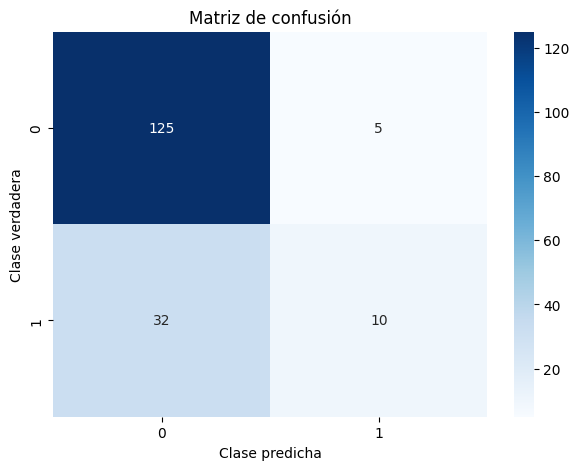

In [7]:
Y_pred = modelo_1.predict(X_validacion)

accuracy_modelo_1 = accuracy_score(Y_validacion, Y_pred)
print(f'Precisión del modelo: {accuracy_modelo_1:.2f}')

utilidades.plot_confusion_matrix(Y_validacion, Y_pred)

Se observa que el modelo tiene problemas para predecir la clase 1 (minoritaria), y está más sesgado a predecir la clase 0.

### 3.2 Modelo 2: Red neuronal de una sola neurona sin función de activación

A continuación se crea un modelo compuesto por una sola capa lineal, con 2 salidas, sin función de activación.
Se toma como clase predicha cual salida es mayor.

In [8]:
# Creacion del modelo
modelo_2 = Modelo_2(cant_caracteristicas).to(device)

# Creacion de los dataloaders
data_loader_train_2 = utilidades.crear_data_loader(X_train, Y_train, batch_size=8, dos_salidas=True, device=device)
data_loader_validacion_2 = utilidades.crear_data_loader(X_validacion, Y_validacion, batch_size=8, dos_salidas=True, device=device)

# Definición de la función de pérdida y el optimizador
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.Adam(modelo_2.parameters(), lr=0.0035)
entrenador_2 = Entrenador(modelo_2, data_loader_train_2, criterion_2, optimizer_2, dos_salidas=True)

perdida_train_evolucion_2 = []
perdida_validacion_evolucion_2 = []
accuracy_train_evolucion_2 = []
accuracy_validacion_evolucion_2 = []
epocas = 100

for epoca in range(epocas):
    entrenador_2.entrenar()

    # Se evalua y guarda la perdida del modelo en el set de entrenamiento y validacion
    loss_train = entrenador_2.evaluar_loss(data_loader_train_2)
    loss_validacion = entrenador_2.evaluar_loss(data_loader_validacion_2)
    perdida_train_evolucion_2.append(loss_train)
    perdida_validacion_evolucion_2.append(loss_validacion)

    # Se evalua y guarda la precision del modelo en el set de entrenamiento y validacion
    accuracy_train = entrenador_2.evaluar_accuracy(data_loader_train_2)
    accuracy_validacion = entrenador_2.evaluar_accuracy(data_loader_validacion_2)
    accuracy_train_evolucion_2.append(accuracy_train)
    accuracy_validacion_evolucion_2.append(accuracy_validacion)

    if epoca % 10 == 0:
        print(f'Epoca {epoca} completada') 

Epoca 0 completada
Epoca 10 completada
Epoca 20 completada
Epoca 30 completada
Epoca 40 completada
Epoca 50 completada
Epoca 60 completada
Epoca 70 completada
Epoca 80 completada
Epoca 90 completada


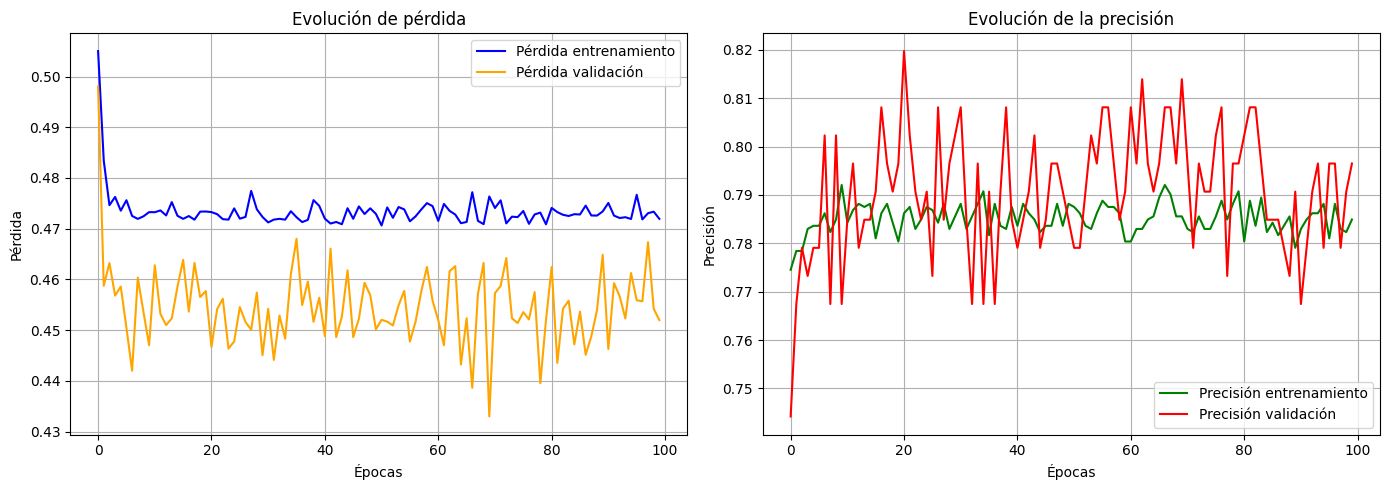

In [9]:
utilidades.graficar_metricas(perdida_train_evolucion_2, perdida_validacion_evolucion_2, accuracy_train_evolucion_2, accuracy_validacion_evolucion_2)

Si se observa la evolución de la pérdida, en ambos conjuntos no parece haber un aprendizaje luego de las primeras 5 epocas.

Además, se observa que la precisión en el conjunto de validación oscila, un posible motivo es que al no poseer una función de activación no se normalizan los valores.


### 3.3 Modelo 3: Red neuronal de una sola neurona con función de activación

A continuación se crea un modelo compuesto por una sola capa lineal, con una salida, y función de activación sigmoide.
Se toma como clase predicha 1 si el resultado es mayor o igual a 0.5, y 0 en caso contrario.

In [10]:
# Creacion del modelo
modelo_3 = Modelo_3(cant_caracteristicas).to(device)

# Creacion de los dataloaders
data_loader_train_3 = utilidades.crear_data_loader(X_train, Y_train, batch_size=8, dos_salidas=False, device=device)
data_loader_validacion_3 = utilidades.crear_data_loader(X_validacion, Y_validacion, batch_size=8, dos_salidas=False, device=device)

# Definición de la función de pérdida y el optimizador
criterion_3 = nn.BCELoss()
optimizer_3 = optim.Adam(modelo_3.parameters(), lr=0.0035)
entrenador_3 = Entrenador(modelo_3, data_loader_train_3, criterion_3, optimizer_3, dos_salidas=False)

perdida_train_evolucion_3 = []
perdida_validacion_evolucion_3 = []
accuracy_train_evolucion_3 = []
accuracy_validacion_evolucion_3 = []
epocas = 100

for epoca in range(epocas):
    entrenador_3.entrenar()

    # Se evalua y guarda la perdida del modelo en el set de entrenamiento y validacion
    loss_train = entrenador_3.evaluar_loss(data_loader_train_3)
    loss_validacion = entrenador_3.evaluar_loss(data_loader_validacion_3)
    perdida_train_evolucion_3.append(loss_train)
    perdida_validacion_evolucion_3.append(loss_validacion)

    # Se evalua y guarda la precision del modelo en el set de entrenamiento y validacion
    accuracy_train = entrenador_3.evaluar_accuracy(data_loader_train_3)
    accuracy_validacion = entrenador_3.evaluar_accuracy(data_loader_validacion_3)
    accuracy_train_evolucion_3.append(accuracy_train)
    accuracy_validacion_evolucion_3.append(accuracy_validacion)

    if epoca % 10 == 0:
        print(f'Epoca {epoca} completada') 

Epoca 0 completada
Epoca 10 completada
Epoca 20 completada
Epoca 30 completada
Epoca 40 completada
Epoca 50 completada
Epoca 60 completada
Epoca 70 completada
Epoca 80 completada
Epoca 90 completada


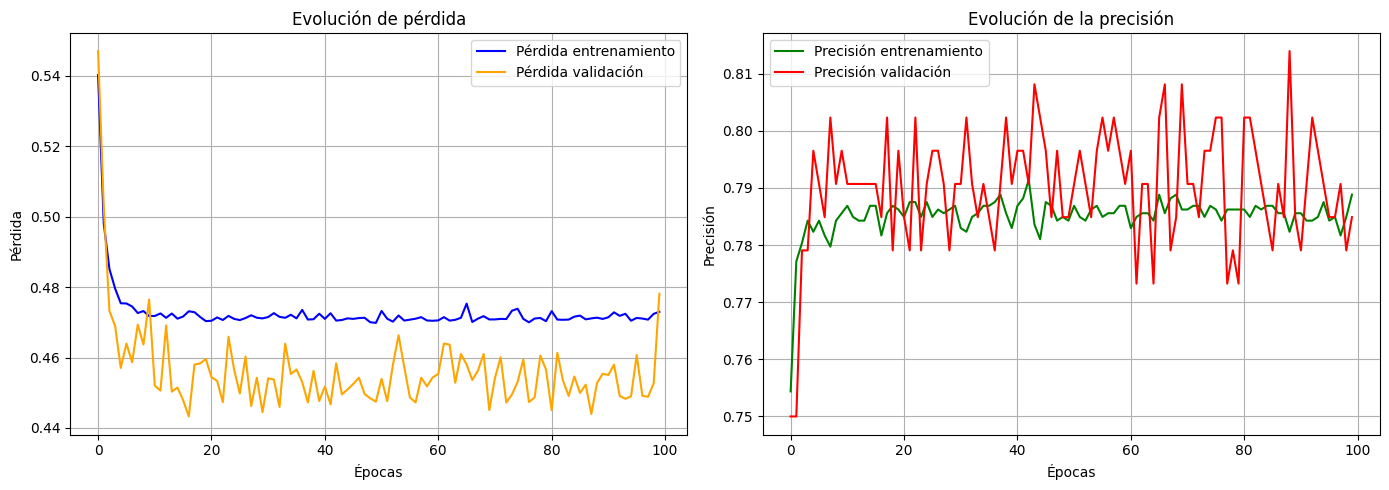

In [11]:
utilidades.graficar_metricas(perdida_train_evolucion_3, perdida_validacion_evolucion_3, accuracy_train_evolucion_3, accuracy_validacion_evolucion_3)

En comparación al resultado del modelo 1, se observa un comportamiento más estable, aunque todavía errático. En este caso, el aprendizaje parece continuar hasta la época 10, para luego estancarse. De todas formas, no obtiene mejores resultados que su contraparte.

### 3.4 Modelo 4: Red neuronal con capas ocultas y función de activación

A continuación se crea un modelo que hace uso de una capa oculta con 16 neuronas y función de activación sigmoide, con una unica salida, con la misma función de activacion.
Se toma como clase predicha 1 si el resultado es mayor o igual a 0.5, y 0 en caso contrario.

In [12]:
# Creacion del modelo
modelo_4 = Modelo_4(cant_caracteristicas).to(device)

# Creacion de los dataloaders
data_loader_train_4 = utilidades.crear_data_loader(X_train, Y_train, batch_size=8, device=device)
data_loader_validacion_4 = utilidades.crear_data_loader(X_validacion, Y_validacion, batch_size=8, device=device)

# Definición de la función de pérdida y el optimizador
criterion_4 = nn.BCELoss()
optimizer_4 = optim.Adam(modelo_4.parameters(), lr=0.0035)
entrenador_4 = Entrenador(modelo_4, data_loader_train_4, criterion_4, optimizer_4)

perdida_train_evolucion_4 = []
perdida_validacion_evolucion_4 = []
accuracy_train_evolucion_4 = []
accuracy_validacion_evolucion_4 = []
epocas = 100

for epoca in range(epocas):
    entrenador_4.entrenar()
    
    # Se evalua y guarda la perdida del modelo en el set de entrenamiento y validacion
    loss_train = entrenador_4.evaluar_loss(data_loader_train_4)
    loss_validacion = entrenador_4.evaluar_loss(data_loader_validacion_4)
    perdida_train_evolucion_4.append(loss_train)
    perdida_validacion_evolucion_4.append(loss_validacion)

    # Se evalua y guarda la precision del modelo en el set de entrenamiento y validacion
    accuracy_train = entrenador_4.evaluar_accuracy(data_loader_train_4)
    accuracy_validacion = entrenador_4.evaluar_accuracy(data_loader_validacion_4)
    accuracy_train_evolucion_4.append(accuracy_train)
    accuracy_validacion_evolucion_4.append(accuracy_validacion)

    if epoca % 10 == 0:
        print(f'Epoca {epoca} completada')

Epoca 0 completada
Epoca 10 completada
Epoca 20 completada
Epoca 30 completada
Epoca 40 completada
Epoca 50 completada
Epoca 60 completada
Epoca 70 completada
Epoca 80 completada
Epoca 90 completada


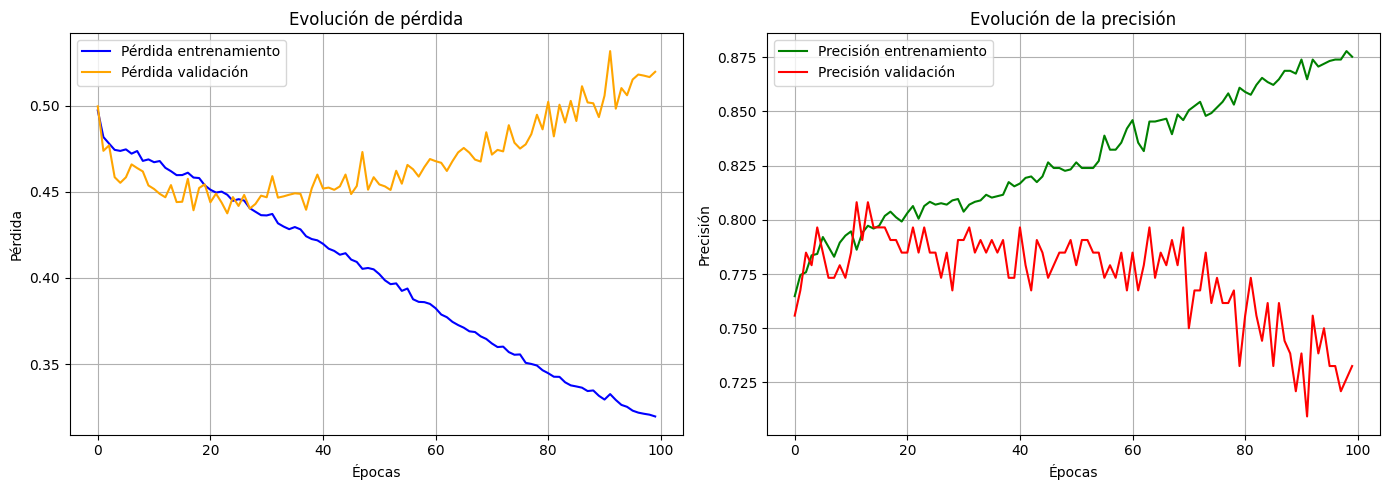

In [13]:
utilidades.graficar_metricas(perdida_train_evolucion_4, perdida_validacion_evolucion_4, accuracy_train_evolucion_4, accuracy_validacion_evolucion_4)

Se observa como el modelo es capaz de aprender a predecir dentro del conjunto de entrenamiento, alcanzando una precisión de casi el 90%. Sin embargo, esto es debido a que el modelo está sobreajustando, por lo que luego de aproximadamente 20 épocas, la pérdida dentro del conjunto de validación comienza a aumentar, y la precisión a disminuir.

### 3.5 Modelo 5: Experimentación de arquitecturas

Se probarán 3 arquitecturas diferentes, variando la cantidad de unidades, capas ocultas y funciones de activación.
Para cada una, se probarán 5 valores diferentes para la tasa de aprendizaje.

In [6]:
tasas_de_aprendizaje = [0.0001, 0.001, 0.005, 0.01, 0.1]

#### 3.5.1: Modelo 5.1

Se utiliza una capa oculta de 32 neuronas, con función de activación LeakyReLU, con una sola salida con función de activación sigmoide. Además, se agrega el uso `regularización L2` utilizando `weight_decay=0.0001`.

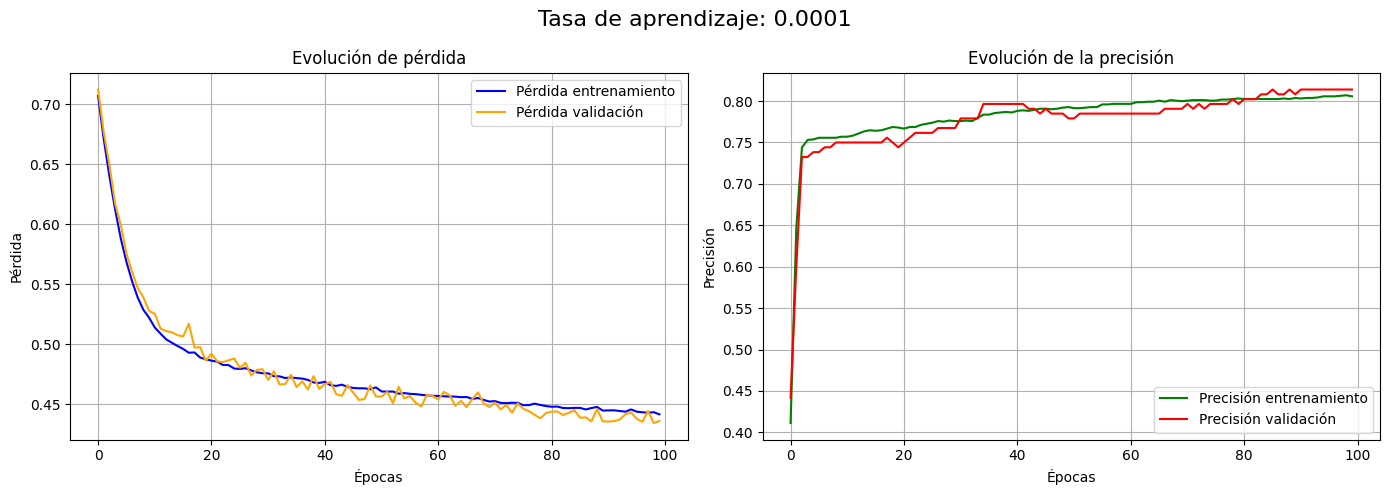

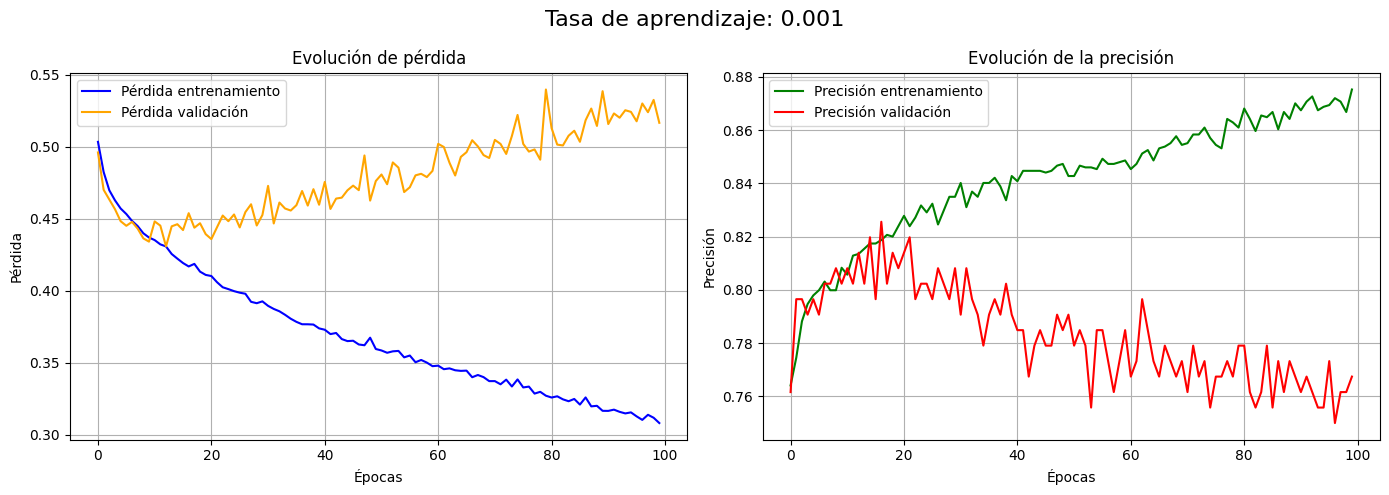

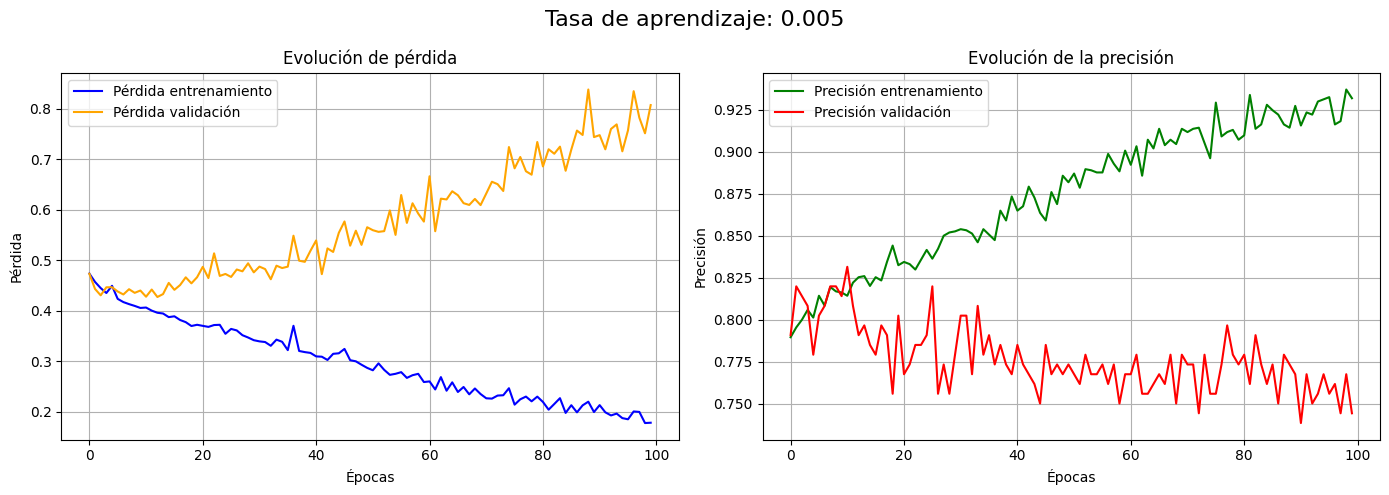

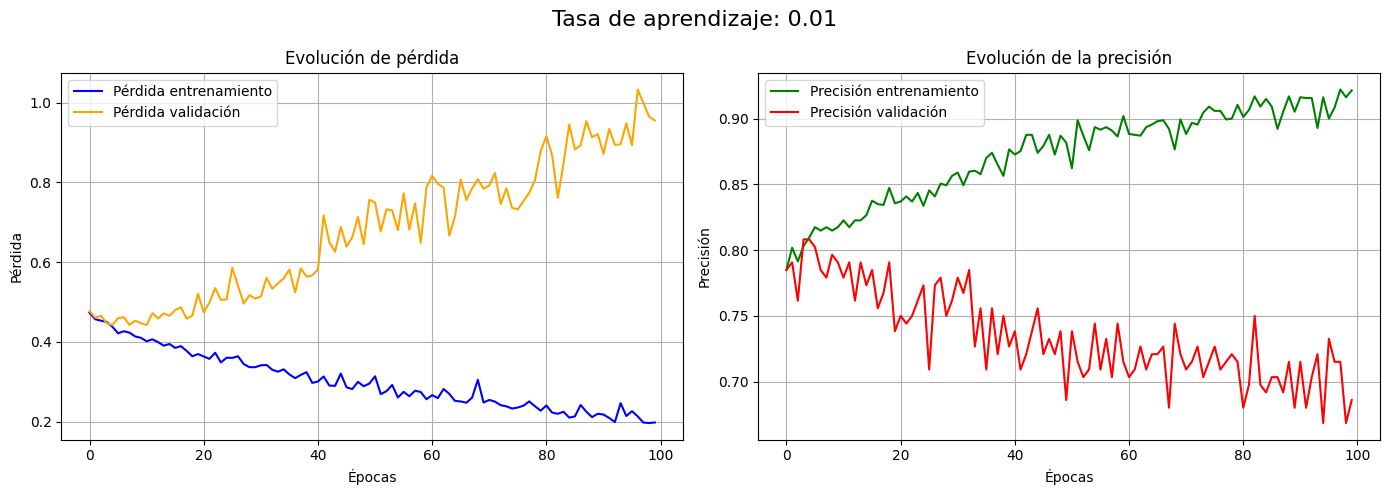

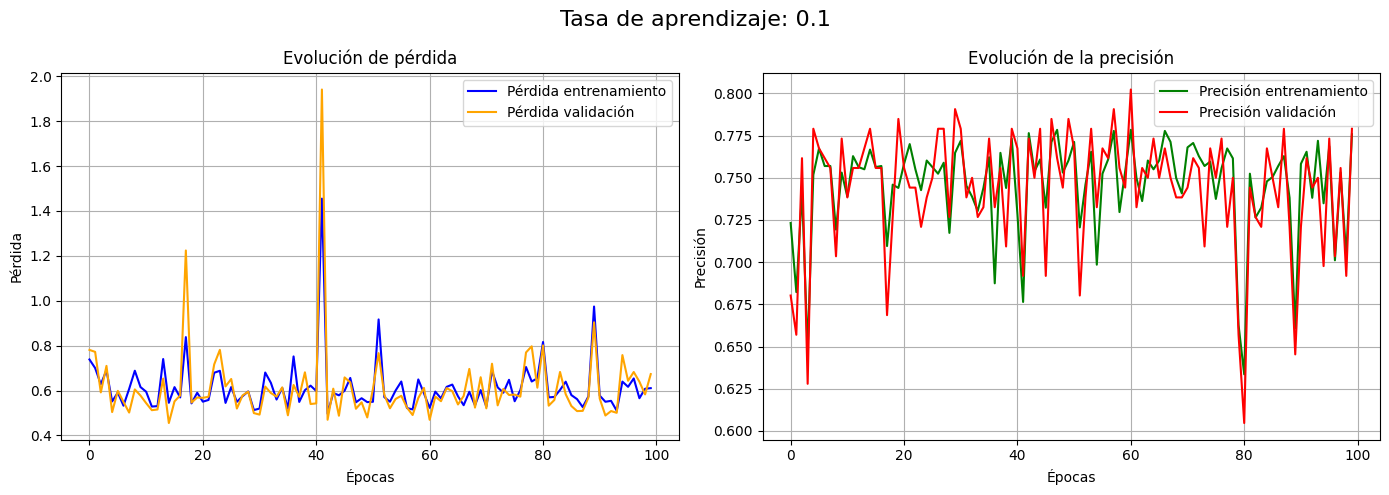

In [15]:
data_loader_train_5_1 = utilidades.crear_data_loader(X_train, Y_train, batch_size=8, device=device)
data_loader_validacion_5_1 = utilidades.crear_data_loader(X_validacion, Y_validacion, batch_size=8, device=device)

criterion_5_1 = nn.BCELoss()

for lr in tasas_de_aprendizaje:
    modelo_5_1 = Modelo_5_1(cant_caracteristicas).to(device) 

    optimizer_5_1 = torch.optim.Adam(modelo_5_1.parameters(), lr=lr, weight_decay=0.0001)
    entrenador_5_1 = Entrenador(modelo_5_1, data_loader_train_5_1, criterion_5_1, optimizer_5_1)

    perdida_train_evolucion_5_1 = []
    perdida_validacion_evolucion_5_1 = []
    accuracy_train_evolucion_5_1 = []
    accuracy_validacion_evolucion_5_1 = []
    epocas = 100

    for epoch in range(epocas):
        entrenador_5_1.entrenar()

        loss_train = entrenador_5_1.evaluar_loss(data_loader_train_5_1)
        loss_validacion = entrenador_5_1.evaluar_loss(data_loader_validacion_5_1)
        perdida_train_evolucion_5_1.append(loss_train)
        perdida_validacion_evolucion_5_1.append(loss_validacion)

        accuracy_train = entrenador_5_1.evaluar_accuracy(data_loader_train_5_1)
        accuracy_validacion = entrenador_5_1.evaluar_accuracy(data_loader_validacion_5_1)
        accuracy_train_evolucion_5_1.append(accuracy_train)
        accuracy_validacion_evolucion_5_1.append(accuracy_validacion)

    utilidades.graficar_metricas(perdida_train_evolucion_5_1, perdida_validacion_evolucion_5_1, accuracy_train_evolucion_5_1, accuracy_validacion_evolucion_5_1, lr)  

El mejor resultado es obtenido al utilizar una tasa de aprendizaje de 0.001, superando el 82% de precisión, sin embargo, la única tasa de aprendizaje que da como resultado un aprendizaje estable es 0.0001. A medida que agrandamos este valor, las métricas comienzan a oscilar, y, luego de 0.005, el modelo no parece ser de utilidad para predecir dentro del conjunto de validación, provocando un sobreajuste casi inmediatamente una vez comenzado el entrenamiento.

#### 3.5.2: Modelo 5.2

Se utiliza una capa oculta de 64 neuronas, con función de activación `SiLU`. Además, se aplica el mecanismo de regularización `Dropout` con un valor de 0.3. Nuevamente se aplica `regularización L2` usando `weight_decay=0.00001`, y se utiliza una única salida con función de activación sigmoide.

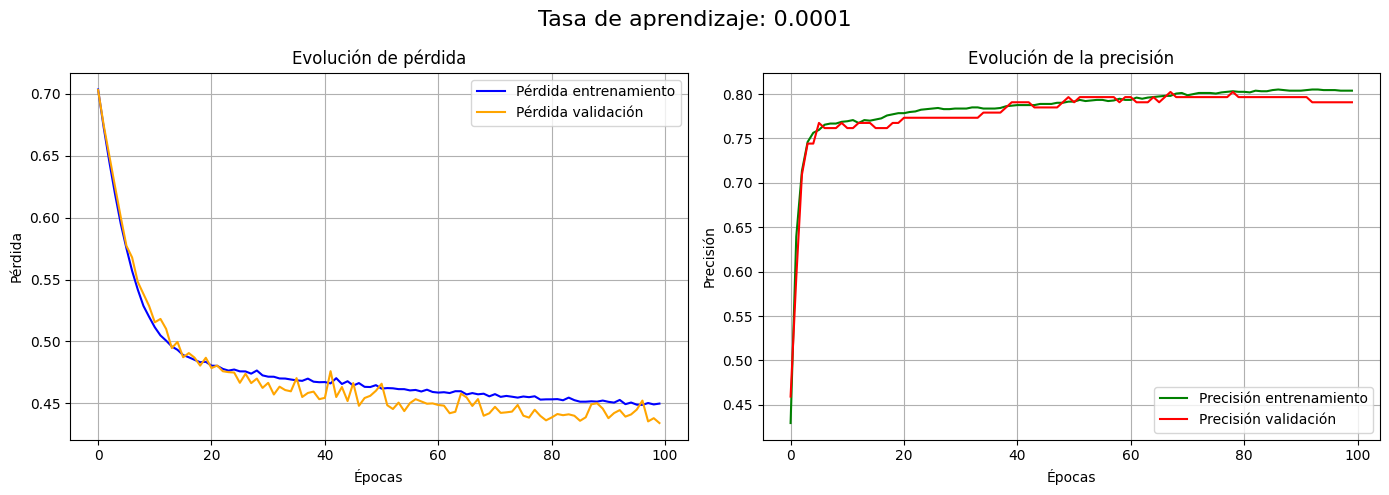

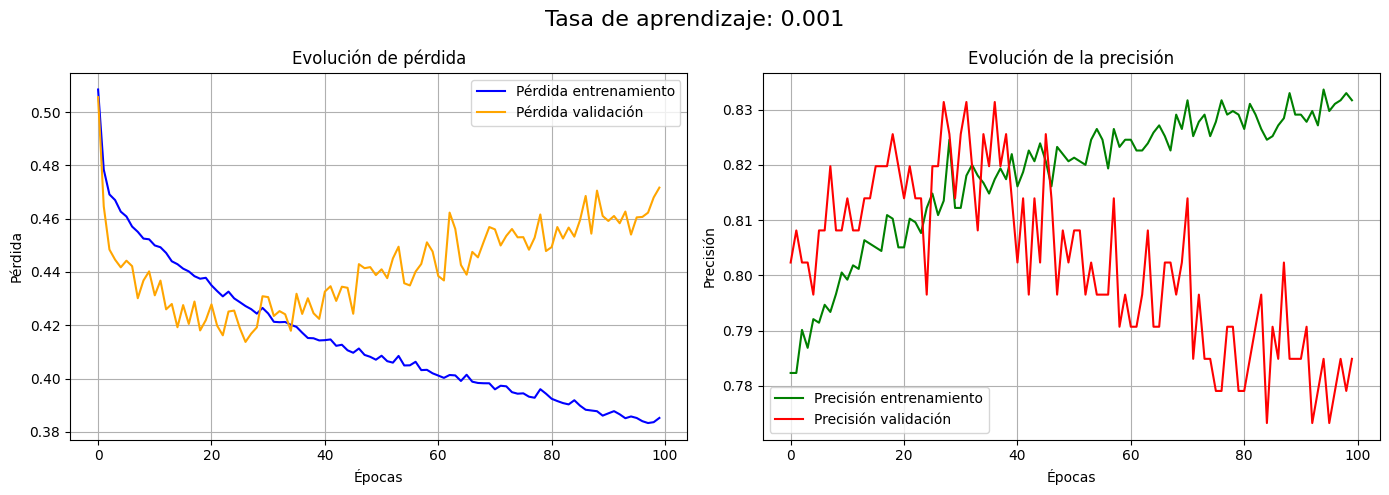

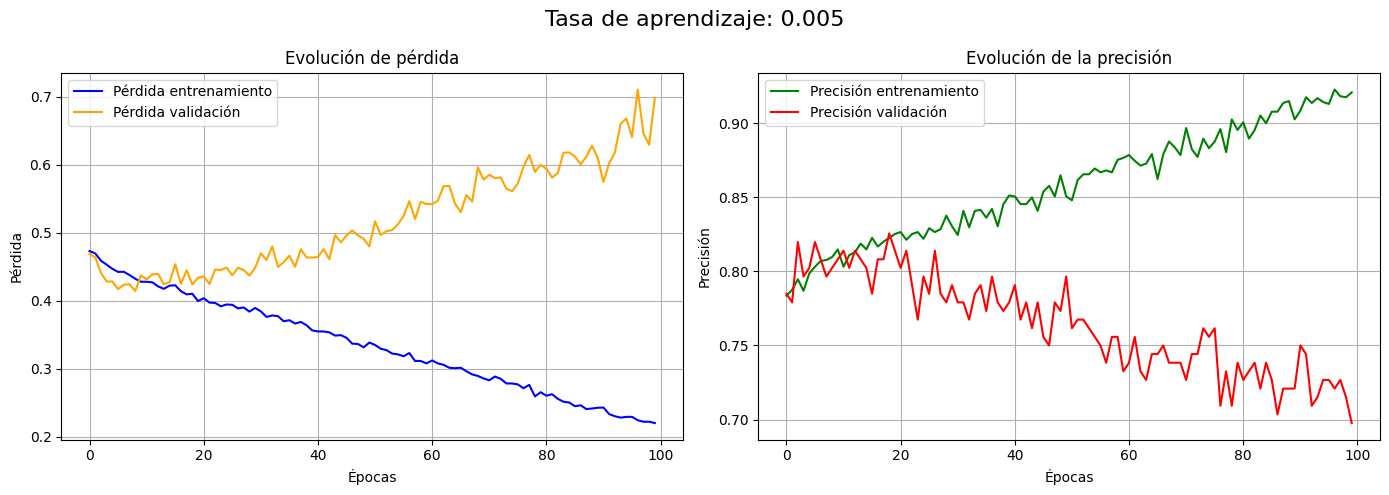

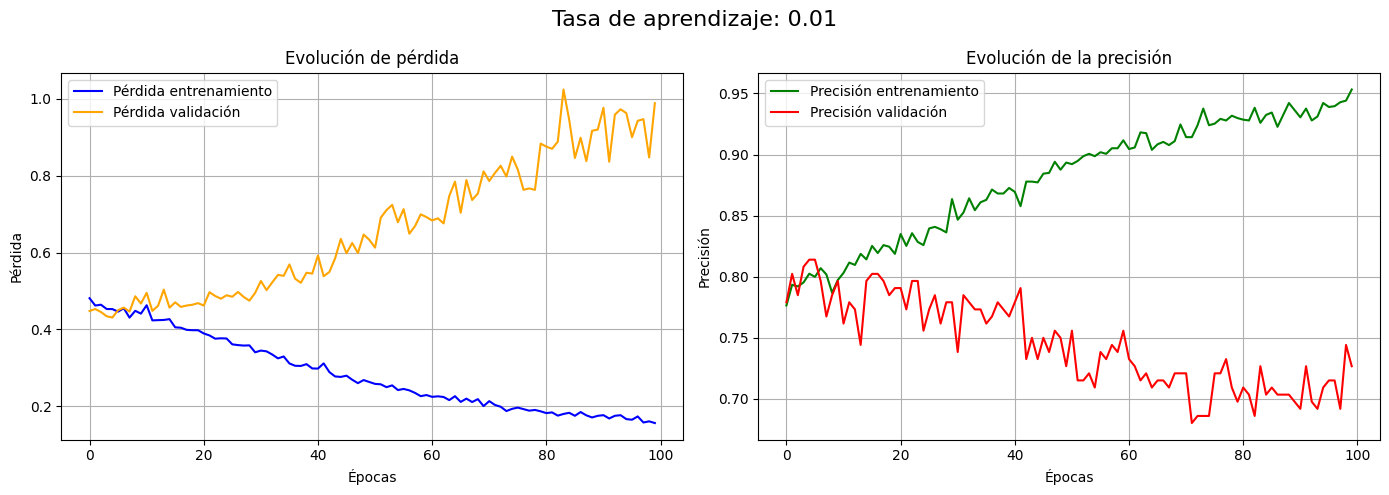

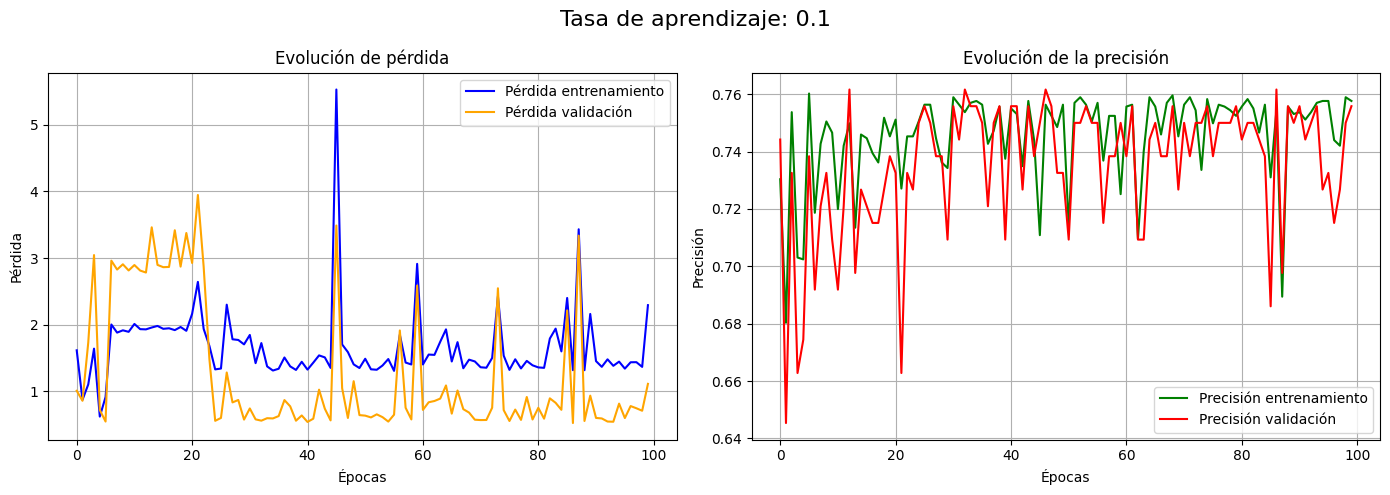

In [16]:
data_loader_train_5_2 = utilidades.crear_data_loader(X_train, Y_train, batch_size=8, device=device)
data_loader_validacion_5_2 = utilidades.crear_data_loader(X_validacion, Y_validacion, batch_size=8, device=device)

criterion_5_2 = nn.BCELoss()

for lr in tasas_de_aprendizaje:
    modelo_5_2 = Modelo_5_2(cant_caracteristicas).to(device) 

    optimizador_5_2 = torch.optim.Adam(modelo_5_2.parameters(), lr=lr, weight_decay=0.00001)
    entrenador_5_2 = Entrenador(modelo_5_2, data_loader_train_5_2, criterion_5_2, optimizador_5_2)

    perdida_train_evolucion_5_2 = []
    perdida_validacion_evolucion_5_2 = []
    accuracy_train_evolucion_5_2 = []
    accuracy_validacion_evolucion_5_2 = []
    epocas = 100

    for epoch in range(epocas):
        entrenador_5_2.entrenar()

        loss_train = entrenador_5_2.evaluar_loss(data_loader_train_5_2)
        loss_validacion = entrenador_5_2.evaluar_loss(data_loader_validacion_5_2)
        perdida_train_evolucion_5_2.append(loss_train)
        perdida_validacion_evolucion_5_2.append(loss_validacion)

        accuracy_train = entrenador_5_2.evaluar_accuracy(data_loader_train_5_2)
        accuracy_validacion = entrenador_5_2.evaluar_accuracy(data_loader_validacion_5_2)
        accuracy_train_evolucion_5_2.append(accuracy_train)
        accuracy_validacion_evolucion_5_2.append(accuracy_validacion)

    utilidades.graficar_metricas(perdida_train_evolucion_5_2, perdida_validacion_evolucion_5_2, accuracy_train_evolucion_5_2, accuracy_validacion_evolucion_5_2, lr)

En comparación al modelo anterior, podemos observar similitudes, por ejemplo, al aumentar el valor de la tasa de aprendizaje. Sin embargo, también notamos como la utilización de Dropout parece haber ayudado a reducir el sobreajuste, si observamos la gráfica correspondiente a la tasa de aprendizaje con valor 0.001, y la comparamos con la del modelo anterior.
Aun así, salvo picos no reproducibles (que dependen de alguna semilla), no observamos una mejora en cuanto a la precisión refiere.

#### 3.5.3: Modelo 5.3

Por último, se propone el uso de una arquitectura con dos capas ocultas, la primera con 64 neuronas, y la segunda con 32 neuronas, ambas con funciones de activación ReLU.
Además, se utilizan 2 salidas, con función de activación Softmax.

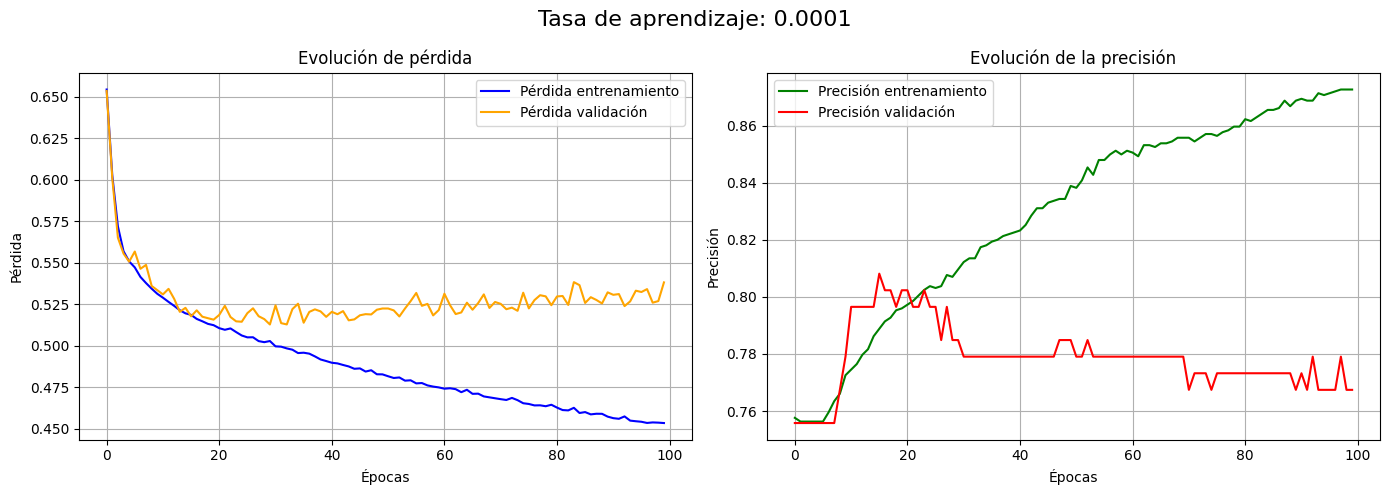

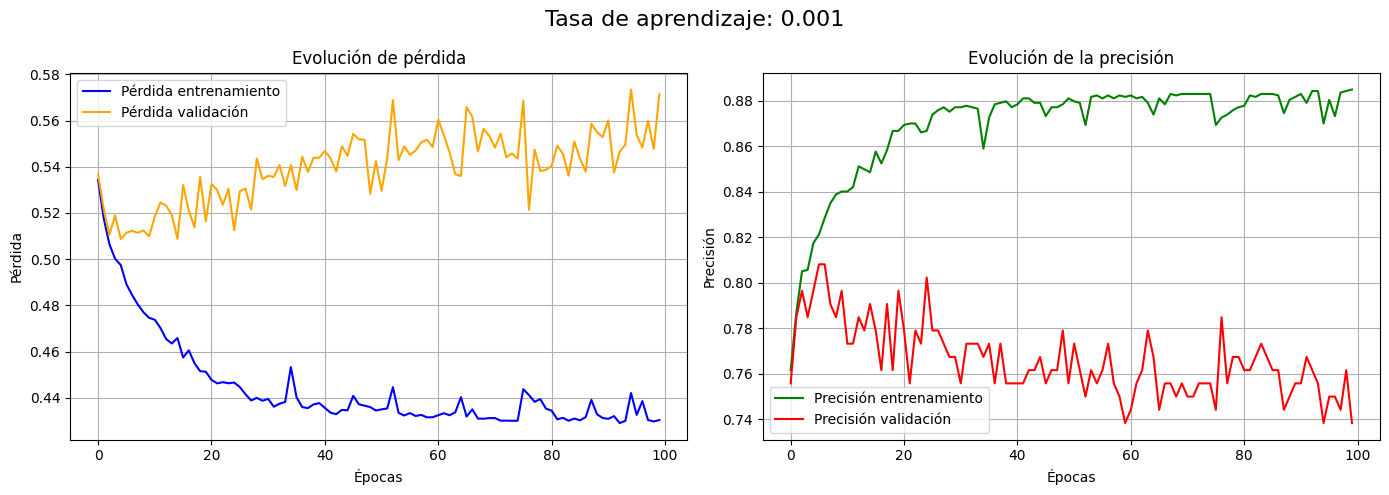

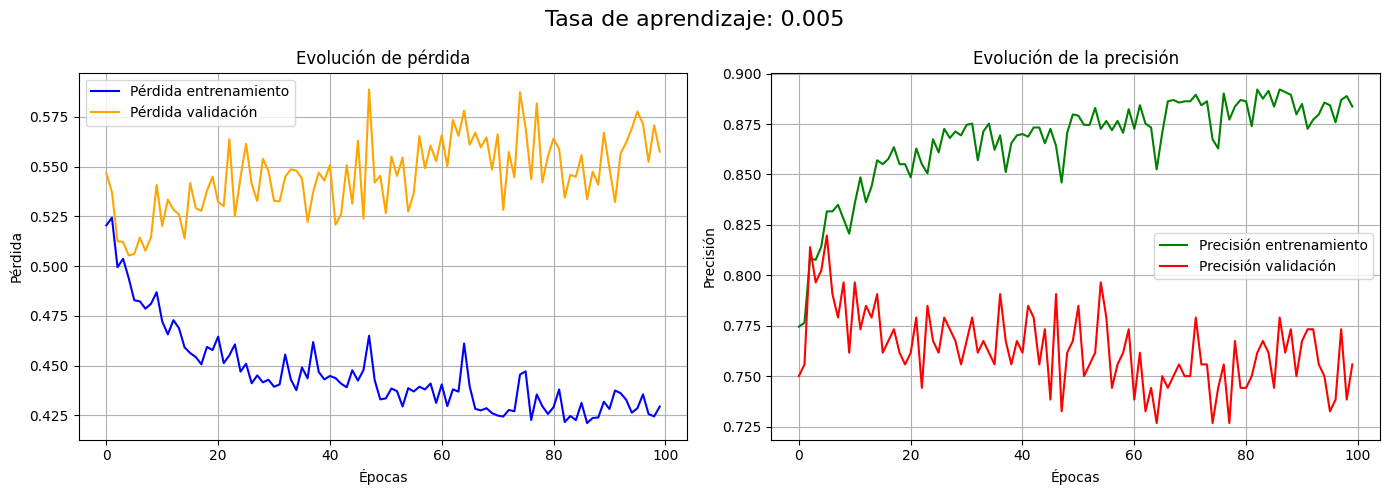

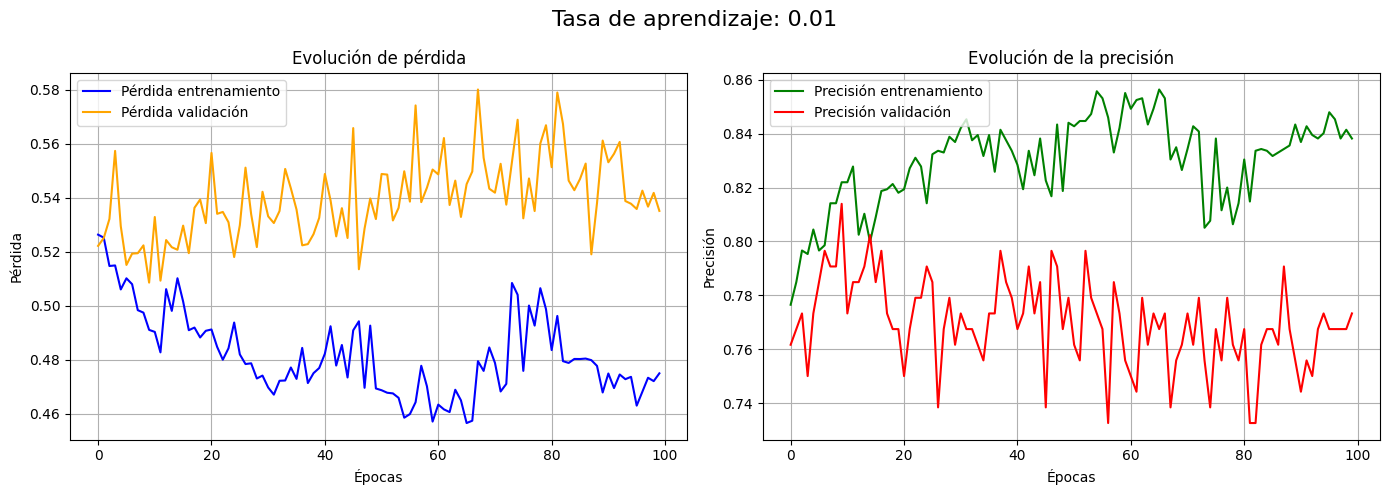

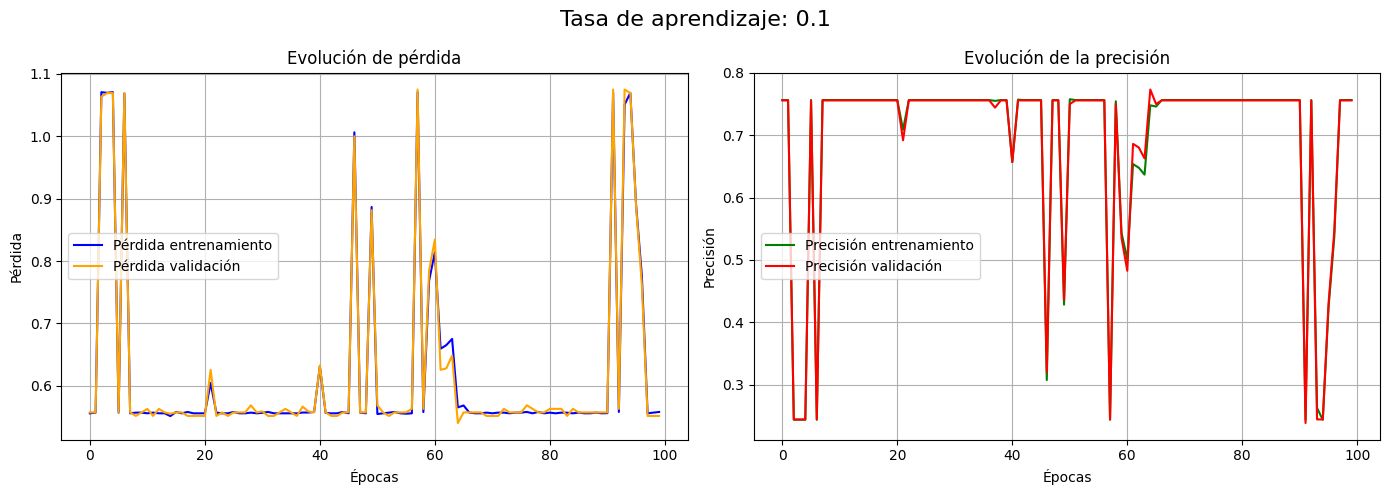

In [18]:
data_loader_train_5_3 = utilidades.crear_data_loader(X_train, Y_train, batch_size=8, dos_salidas=True, device=device)
data_loader_validacion_5_3 = utilidades.crear_data_loader(X_validacion, Y_validacion, batch_size=8, dos_salidas=True, device=device)

criterion_5_3 = nn.CrossEntropyLoss()

for lr in tasas_de_aprendizaje:
    modelo_5_3 = Modelo_5_3(cant_caracteristicas).to(device) 

    optimizer_5_3 = torch.optim.Adam(modelo_5_3.parameters(), lr=lr, weight_decay=0.0001)
    entrenador_5_3 = Entrenador(modelo_5_3, data_loader_train_5_3, criterion_5_3, optimizer_5_3, dos_salidas=True)

    perdida_train_evolucion_5_3 = []
    perdida_validacion_evolucion_5_3 = []
    accuracy_train_evolucion_5_3 = []
    accuracy_validacion_evolucion_5_3 = []
    epocas = 100

    for epoch in range(epocas):
        entrenador_5_3.entrenar()

        loss_train = entrenador_5_3.evaluar_loss(data_loader_train_5_3)
        loss_validacion = entrenador_5_3.evaluar_loss(data_loader_validacion_5_3)
        perdida_train_evolucion_5_3.append(loss_train)
        perdida_validacion_evolucion_5_3.append(loss_validacion)

        accuracy_train = entrenador_5_3.evaluar_accuracy(data_loader_train_5_3)
        accuracy_validacion = entrenador_5_3.evaluar_accuracy(data_loader_validacion_5_3)
        accuracy_train_evolucion_5_3.append(accuracy_train)
        accuracy_validacion_evolucion_5_3.append(accuracy_validacion)

    utilidades.graficar_metricas(perdida_train_evolucion_5_3, perdida_validacion_evolucion_5_3, accuracy_train_evolucion_5_3, accuracy_validacion_evolucion_5_3, lr)

Los resultados de este modelo son sustantivamente inferiores al de los modelos anteriores. Este experimento sirve para comprobar que aumentar la complejidad de la red (en cantidad de capas ocultas) no ayuda a mejorar el desempeño, sino lo contrario. Esto se debe principalmente a que la cantidad de datos es muy pequeña.

## 4. Comparación

A continuación se compararán los 5 modelos desarrollados durante el laboratorio, haciendo uso del conjunto de entrenamiento completo, y se compararán las métricas accuracy, precision, recall y f1 de cada uno.
Como modelo 5, tomaremos el 5.2, es decir, el que hacía uso de una capa oculta de 64 neuronas, con función de activación SiLU, y Dropout con valor 0.3.

In [12]:
# Entrenamos durante la cantidad de epocas que mostraron mejores resultados
cantidad_epocas_modelo_2 = 100
cantidad_epocas_modelo_3 = 100
cantidad_epocas_modelo_4 = 20
cantidad_epocas_modelo_5 = 30

# Se crean dos dataloaders, uno para los modelos con una salida, y otro para los modelos con dos salidas
data_loader_train_una_salida = utilidades.crear_data_loader(X_train_completo, Y_train_completo, batch_size=8, device=device)
data_loader_train_dos_salidas = utilidades.crear_data_loader(X_train_completo, Y_train_completo, batch_size=8, dos_salidas=True, device=device)

# Se crean nuevamente los modelos para entrenarlos desde 0

modelo_1 = LogisticRegression()
modelo_2 = Modelo_2(cant_caracteristicas).to(device)
modelo_3 = Modelo_3(cant_caracteristicas).to(device)
modelo_4 = Modelo_4(cant_caracteristicas).to(device)
modelo_5 = Modelo_5_2(cant_caracteristicas).to(device) 

# Criterios
criterion_2 = nn.CrossEntropyLoss()
criterion_3 = nn.BCELoss()
criterion_4 = nn.BCELoss()
criterion_5 = nn.BCELoss()

# Optimizadores
optimizer_2 = optim.Adam(modelo_2.parameters(), lr=0.0035)
optimizer_3 = optim.Adam(modelo_3.parameters(), lr=0.0035)
optimizer_4 = optim.Adam(modelo_4.parameters(), lr=0.0035)
optimizer_4 = optim.Adam(modelo_4.parameters(), lr=0.0035)
optimizer_5 = optim.Adam(modelo_5.parameters(), lr=0.001, weight_decay=0.00001)

# Entrenadores
entrenador_2 = Entrenador(modelo_2, data_loader_train_dos_salidas, criterion_2, optimizer_2, dos_salidas=True)
entrenador_3 = Entrenador(modelo_3, data_loader_train_una_salida, criterion_3, optimizer_3)
entrenador_4 = Entrenador(modelo_4, data_loader_train_una_salida, criterion_4, optimizer_4)
entrenador_5 = Entrenador(modelo_5, data_loader_train_una_salida, criterion_5, optimizer_5)

# Se entrenan todos los modelos la cantidad optima de epocas para cada uno
modelo_1.fit(X_train_completo, Y_train_completo)
for epoca in range(cantidad_epocas_modelo_2):
    entrenador_2.entrenar()
for epoca in range(cantidad_epocas_modelo_3):
    entrenador_3.entrenar()
for epoca in range(cantidad_epocas_modelo_4):
    entrenador_4.entrenar()
for epoca in range(cantidad_epocas_modelo_5):
    entrenador_5.entrenar()

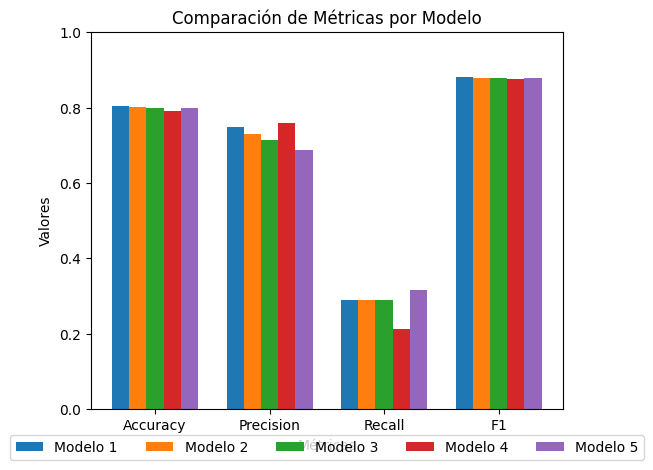

In [13]:
data_loader_test_una_salida = utilidades.crear_data_loader(X_test, Y_test, batch_size=8, device=device)
data_loader_test_dos_salidas = utilidades.crear_data_loader(X_test, Y_test, batch_size=8, dos_salidas=True, device=device)

# Se evaluan los modelos en el conjunto de test

Y_pred_modelo_1 = modelo_1.predict(X_test)
accuracy_1, precision_1, recall_1, f1_1 = accuracy_score(Y_test, Y_pred_modelo_1), precision_score(Y_test, Y_pred_modelo_1), recall_score(Y_test, Y_pred_modelo_1), f1_score(Y_test, Y_pred_modelo_1, pos_label=0)
accuracy_2, precision_2, recall_2, f1_2 = entrenador_2.evaluar_metricas(data_loader_test_dos_salidas)
accuracy_3, precision_3, recall_3, f1_3 = entrenador_3.evaluar_metricas(data_loader_test_una_salida)
accuracy_4, precision_4, recall_4, f1_4 = entrenador_4.evaluar_metricas(data_loader_test_una_salida)
accuracy_5, precision_5, recall_5, f1_5 = entrenador_5.evaluar_metricas(data_loader_test_una_salida)

utilidades.graficar_aprf([accuracy_1, accuracy_2, accuracy_3, accuracy_4, accuracy_5],
                         [precision_1, precision_2, precision_3, precision_4, precision_5],
                         [recall_1, recall_2, recall_3, recall_4, recall_5],
                         [f1_1, f1_2, f1_3, f1_4, f1_5])


En general, no hay grandes diferencias entre cada modelo, aunque para varias ejecuciones, el modelo 5 obtiene mejores resultados en `recall`, mientras que los otros modelos compiten por la mejor `accuracy`, `precision` y `F1`.

Es importante destacar que los resultados varían en cada ejecución, y no siempre se mantiene el mismo orden de desempeño para cada métrica. Al ser modelos con desempeño similar, ninguno es claramente mejor que otro y el no determinismo introducido en el entrenamiento es lo suficientemente relevante como para no llegar a resultados concluyentes.

### 4.2 Resultados de la comparación

A continuación, se resumen todos los resultados obtenidos, incluyendo los de la tarea 1 y 2.


| Modelo            | Accuracy       | Precision | Recall | F1
|-------------------|----------------|-----------|--------|---
| ID3 Manual        | 0.8411         |  -        | -      | 0.8820
| ID3 Librería      | 0.8600         |  -        | -      | 0.9000
| Random Forest     | 0.9000         |  -        | -      | 0.9300
| Naive Bayes       | 0.8474         |  -        | -      | 0.8981
| Modelo 1          | 0.8037         |  0.75     |  0.2884| 0.8820
| Modelo 2          | 0.8014         |  0.7317   |  0.2884| 0.8804
| Modelo 3          | 0.7990         |  0.7142   |  0.2884| 0.8788
| Modelo 4          | 0.7920         |  0.7586   |  0.2115| 0.8769
| Modelo 5          | 0.7990         |  0.6875   |  0.3173| 0.8778


Es importante tomar en cuenta que en este laboratorio, a diferencia de los anteriores, se decidió trabajar sin el atributo `time`, el cual fue útil y brindó mucha información para la predicción de los modelos, por lo que es razonable esperar que los resultados obtenidos sean por debajo de los anteriores. 

## 5. Conclusiones
A modo de conclusión general, se logra implementar un predictor de mortalidad en pacientes con VIH utilizando Redes Neuronales con `pytorch`, aprovechando herramientas de metodología para profundizar el análisis de rendimiento y tomar decisiones en base a ellas.

Los resultados finales muestran que las redes neuronales utilizadas en este problema no tienen mejor desempeño que ninguno de los modelos de laboratorios anteriores.

También, se desprenden las siguientes conclusiones particulares:

- __El alto grado de aleatoriedad complica obtener resultados concluyentes:__ A pesar de los esfuerzos por fijar las semillas para el entrenamiento de los modelos, el _no determinismo_ impacta en aquellos experimentos que son más inestables. Esto implica que ejecutar dos veces el mismo experimento puede variar fuertemente el resultado. Un ejemplo es que al evaluar sobre test, el _«mejor modelo»_ cambia para cada métrica.


- __Aumentar la complejidad del modelo (en cantidad de capas) empeora el aprendizaje:__ Esto puede deberse a que la cantidad de datos del problema es pequeña (cerca de 2000 datos), por lo que utilizar redes complejas puede ser contraproducente.

- __El uso de `Dropout` y `regularización L2` mostró mejoras estables:__ Esto se manifiesta al visualizar los datos de entrenamiento, donde el sobreajuste se ve mitigado cuando se utilizan estas técnicas.

- __No encontramos correlaciones de mejora de desempeño al variar los otros aspectos de la arquitectura:__ Sean estas la función de activación, o la cantidad de neuronas en cada una.

- __El atributo `time` impacta fuertemente a favor del desempeño del modelo:__ La letra del laboratorio pedía explícitamente eliminar el atributo `time`. De manera extraoficial (no documentados en este informe) realizamos experimentos agregándolo, y los resultados superaban el 90% en precisión, siendo sustantivamente superior a cualquiera de los modelos de este y anteriores laboratorios. Esto puede explicar por qué las redes neuronales tuvieron un mal desempeño en comparación a su contraparte.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d290ba77-f85f-4658-8168-f585f89f4dfe' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>